Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910458.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910459.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910460.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910461.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910462.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910463.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910464.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910465.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910466.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910467.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910468.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910469.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910470.mp3
Processing file: C:\PBL_PRAC\LSTM_\실제음성\common_voice_en_17910471.mp3
Processing file: C:\PBL_PRAC\LSTM_

c:\Users\dlath\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


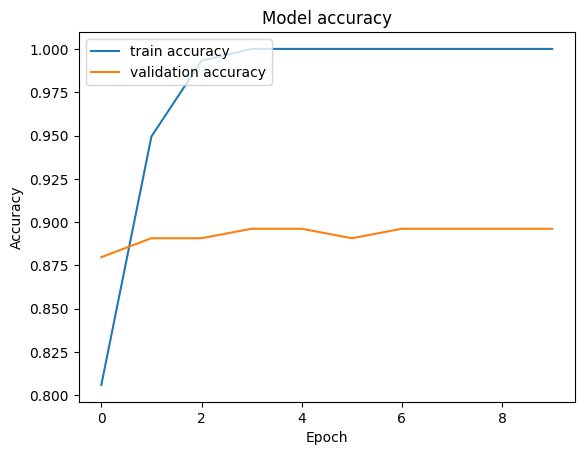

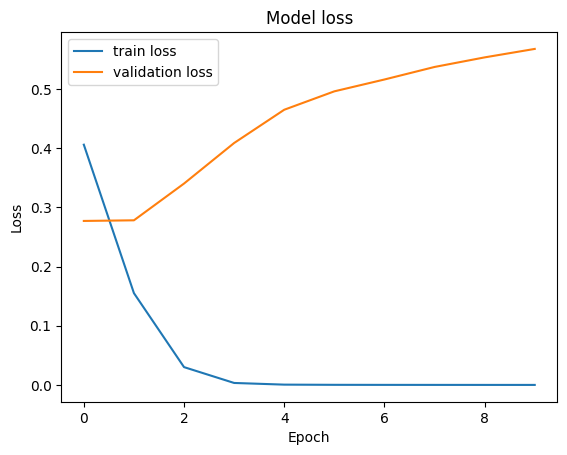

1/1 [==============================] - 1s 672ms/step
이 음성 파일은 'machine' 음성으로 예측되었습니다.


In [9]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

# MFCC 추출 및 패딩 함수
def extract_mfcc(file_path, n_mfcc=20, n_fft=2048, hop_length=512, max_pad_len=174):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

# 데이터셋 로드 함수
def load_dataset(data_dir, label, n_mfcc=20, max_pad_len=174):
    features = []
    labels = []

    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} does not exist.")
        return np.array(features), np.array(labels)

    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.mp3'):
                file_path = os.path.join(subdir, file)
                print(f"Processing file: {file_path}")  # 디버깅 메시지
                try:
                    mfcc = extract_mfcc(file_path, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
                    features.append(mfcc)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    if not features:
        print(f"Warning: No audio files found in {data_dir}")
        
    return np.array(features), np.array(labels)

# 진짜 사람 음성 데이터와 기계 음성 데이터 경로
real_voice_dir = r'C:\PBL_PRAC\LSTM_\실제음성'  # 실제 사람 음성 데이터 경로
machine_voice_dir = r'C:\PBL_PRAC\LSTM_\fake'  # 기계 음성 데이터 경로

# 데이터셋 로드
real_features, real_labels = load_dataset(real_voice_dir, label='real')
machine_features, machine_labels = load_dataset(machine_voice_dir, label='machine')

# 데이터셋 병합
features = np.concatenate((real_features, machine_features), axis=0)
labels = np.concatenate((real_labels, machine_labels), axis=0)

# 데이터 셰이프 출력
print('Features shape:', features.shape)
print('Labels shape:', labels.shape)

# 레이블 인코딩
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, random_state=42)

# LSTM 입력 형식에 맞게 형상 변경
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# LSTM 모델 정의
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        LSTM(128),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # 이진 분류: 사람 vs 기계
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

# 모델 요약 정보 출력
model.summary()

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'테스트 정확도: {test_acc:.4f}')

# 모델 저장
model.save('lstm_audio_classification_model.h5')
print("모델이 'lstm_audio_classification_model.h5'로 성공적으로 저장되었습니다.")

# 학습 곡선 시각화
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 새로운 음성 파일 예측
# 모델 로드
model = load_model('lstm_audio_classification_model.h5')

# 새로운 음성 파일 경로
new_audio_file_path = r'C:\PBL_PRAC\LSTM_\fakeen\common_voice_en_39586336.mp3'  # 여기에 새 음성 파일 경로를 넣으세요.

# 새로운 음성 파일의 MFCC 추출
new_mfcc = extract_mfcc(new_audio_file_path)

# 모델 입력 형식에 맞게 형상 변경
new_mfcc = np.expand_dims(new_mfcc, axis=0)
new_mfcc = np.expand_dims(new_mfcc, axis=-1)

# 예측 수행
predictions = model.predict(new_mfcc)
predicted_label = np.argmax(predictions, axis=1)

# 레이블 디코딩
label_decoder = {0: 'machine', 1: 'real'}
predicted_class = label_decoder[predicted_label[0]]

print(f"이 음성 파일은 '{predicted_class}' 음성으로 예측되었습니다.")
